### `UR5e`

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `scene_ur5e.xml`

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=True)
print ("[%s] parsed."%(env.name))

obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.72,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[50]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', None, None, None, None, None, No

### Render

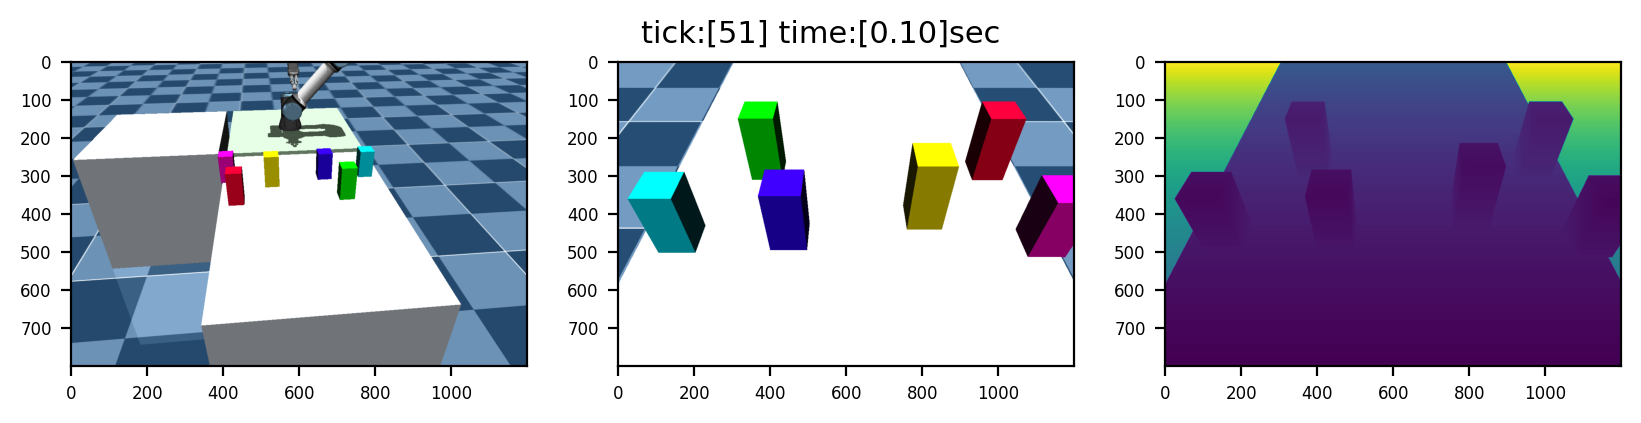

Pressed ESC
Quitting.
Done.


In [3]:
env.init_viewer(viewer_title='UR5e',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_configurations = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
env.forward(q=init_configurations,joint_idxs=env.idxs_forward)

while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    env.step(ctrl=init_configurations,ctrl_idxs=env.idxs_step)

    # Compute some poses
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # Get PCD from a specific view
    p_ego  = p_cam
    p_trgt = p_cam + R_cam[:,2]

    rgb_img,depth_img,pcd, xyz_img = env.get_egocentric_rgb_depth_pcd(
        p_ego=p_ego,p_trgt=p_trgt,rsz_rate=15,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

    env.render(render_every=5)

    # if env.loop_every(HZ=1): 
        # scene_img = env.grab_image()

    # Plot
    if env.loop_every(HZ=10):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()

# Close viewer
env.close_viewer()
print ("Done.")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance
import math
import sys
sys.path.append('..')

# mujoco intrinsics

# Camera intrinsic
img_height = 800  # depth_img.shape[0]
img_width = 1200  # depth_img.shape[1]
fovy = 45
focal_scaling = 0.5*img_height/np.tan(fovy*np.pi/360)
cam_matrix = np.array(((focal_scaling, 0, img_width/2),
                       (0, focal_scaling, img_height/2),
                       (0, 0, 1)))


def get_pointcloud(depth, cam_matrix):
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - cam_matrix[0, 2]) * (depth / cam_matrix[0, 0])
    py = (py - cam_matrix[1, 2]) * (depth / cam_matrix[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points


def get_heightmap(points, bounds, pixel_size):
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (
        points[Ellipsis, 0] < bounds[0, 1])  # Range of the X
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (
        points[Ellipsis, 1] < bounds[1, 1])  # Range of the Y
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (
        points[Ellipsis, 2] < bounds[2, 1])  # Range of the Z
    valid = ix & iy & iz
    points = points[valid]
    points.shape
    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points = points[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]  # Depth value
    return heightmap


def transform_pointcloud(points, transform):
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            'constant', constant_values=1)
    for i in range(3):
        points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

def restore(ortho_image):
    ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
    i_lst, j_lst    = np.where(ortho_image==0)
    sel_value       = np.array([np.average(ortho_image[i-1:i+1,j])*2 if np.isfinite(np.average(ortho_image[i-1:i+1,j])*2) else 0 for (i, j) in zip(i_lst, j_lst)])
    ortho_image_new[i_lst, j_lst] = sel_value
    ortho_image_new+=ortho_image
    return ortho_image_new 

def restore_w(ortho_image):
    ortho_image_new = np.zeros(shape=(ortho_image.shape[0], ortho_image.shape[1]))
    i_lst, j_lst    = np.where(ortho_image==0)
    sel_value       = np.array([np.average(ortho_image[i-1:i+1,j])*2 if np.isfinite(np.average(ortho_image[i-1:i+1,j])*2) else 0 for (i, j) in zip(i_lst, j_lst)])
    ortho_image_new[i_lst, j_lst] = sel_value
    ortho_image_new+=ortho_image
    i_lst2, j_lst2 =  list(set(i_lst)), list(set(j_lst))
    set_value2 = np.array([(i,j) for i in i_lst2[2:-2] for j in j_lst2[2:-2] if ((ortho_image_new[i+2][j]==0) and (ortho_image_new[i-2][j]==0) or (ortho_image_new[i][j+2]==0) and (ortho_image_new[i][j-2]==0))])
    ortho_image_new[set_value2[:,0], set_value2[:,1]]=0
    return ortho_image_new 

def ortho_projection(image, cam_matrix):
    width = 800
    height = 1200
    # Preprocessing
    image = image.reshape((width, height))  # Image shape [Width x Height]

    # Orthographic projection
    points = get_pointcloud(image*1.2, cam_matrix)

    # Homogeneous Matrix
    # rot_mat = Rotation_X(-np.deg2rad(40))
    # trans_mat = Translation(x=-0., y=0.3, z=1.25-0.79)
    # homo_mat  = HT_matrix(Rotation=rot_mat, Position=trans_mat)
    # homo_inv_mat = np.linalg.inv(homo_mat)

    homo_inv_mat =np.array([[ 1.,          0.,          0.,          0.        ],
                            [ 0.,          0.76604444, -0.64278761,  0.06586897],
                            [ 0.,          0.64278761,  0.76604444, -0.54521673],
                            [ 0.,          0.,          0.,          1.        ]])

    new_points = transform_pointcloud(points, homo_inv_mat)
    new_bounds = np.array([[-0.45,0.45], 
                        [-1.05,-0.35],
                        [-1.,2]])
    ortho_image = get_heightmap(new_points, new_bounds, pixel_size=0.0045)/2
    # ortho_image = restore_w(ortho_image)
    return ortho_image


In [5]:
# from uttil_projection import *

ortho_projected_img = ortho_projection(depth_img, cam_matrix)

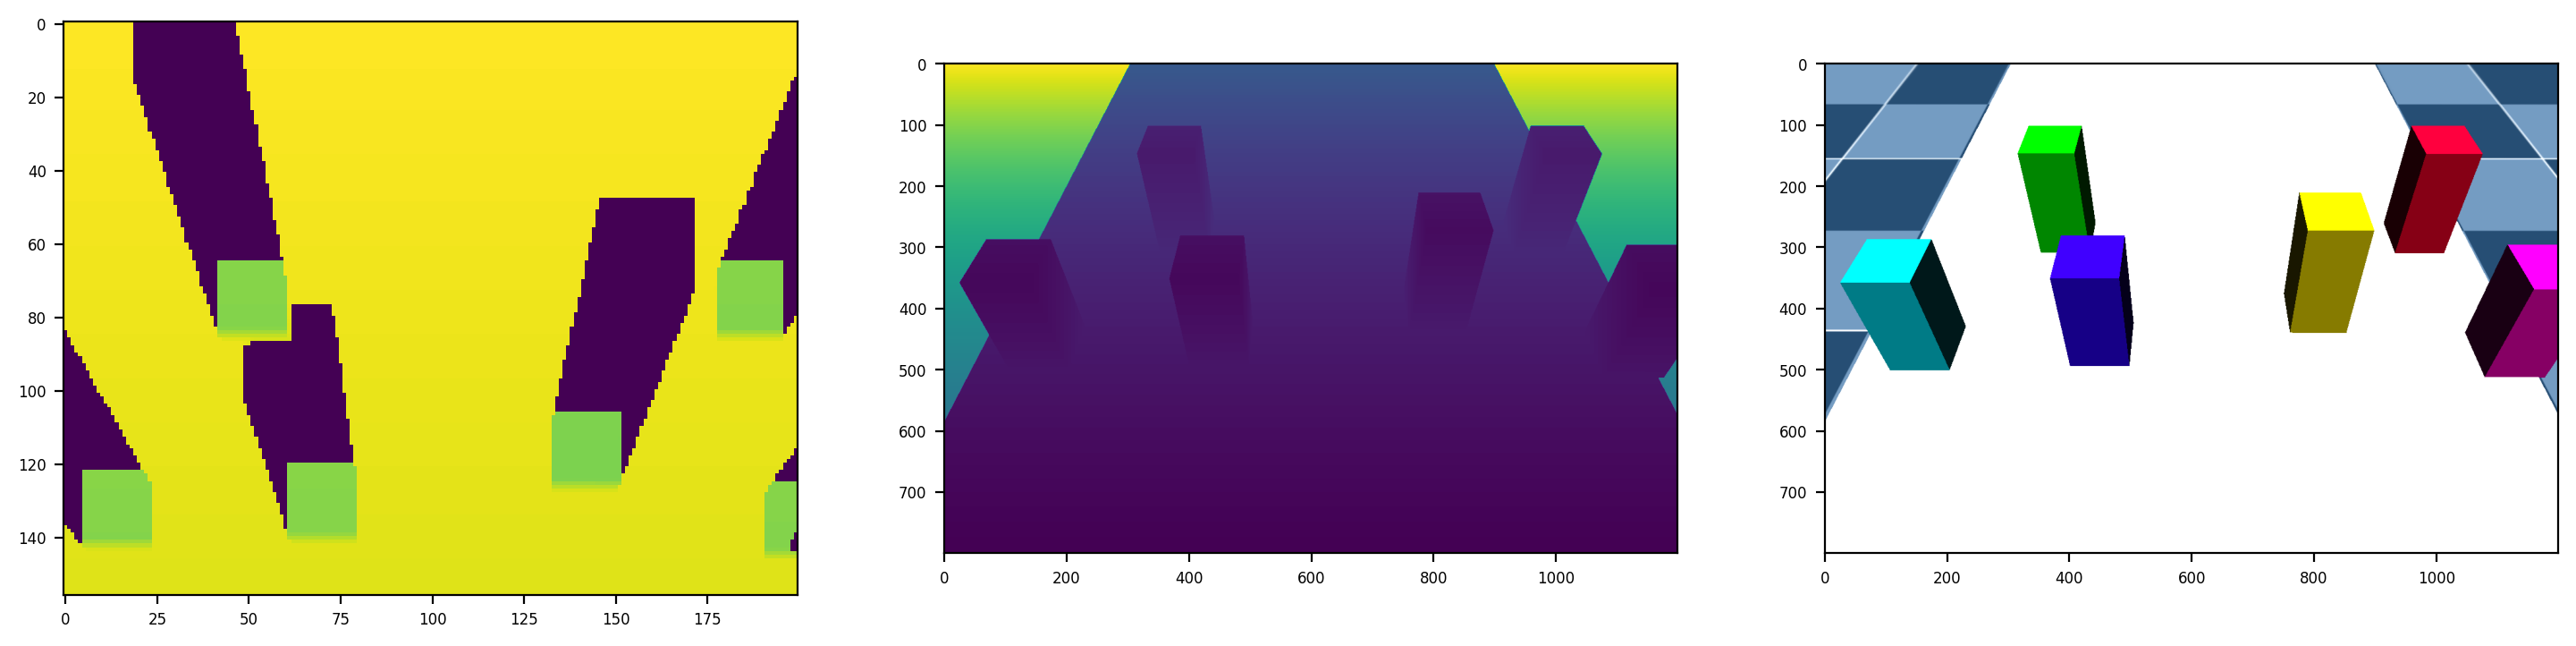

In [6]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(ortho_projected_img)
plt.subplot(1,3,2)
plt.imshow(depth_img)
plt.subplot(1,3,3)
plt.imshow(rgb_img)
plt.show()


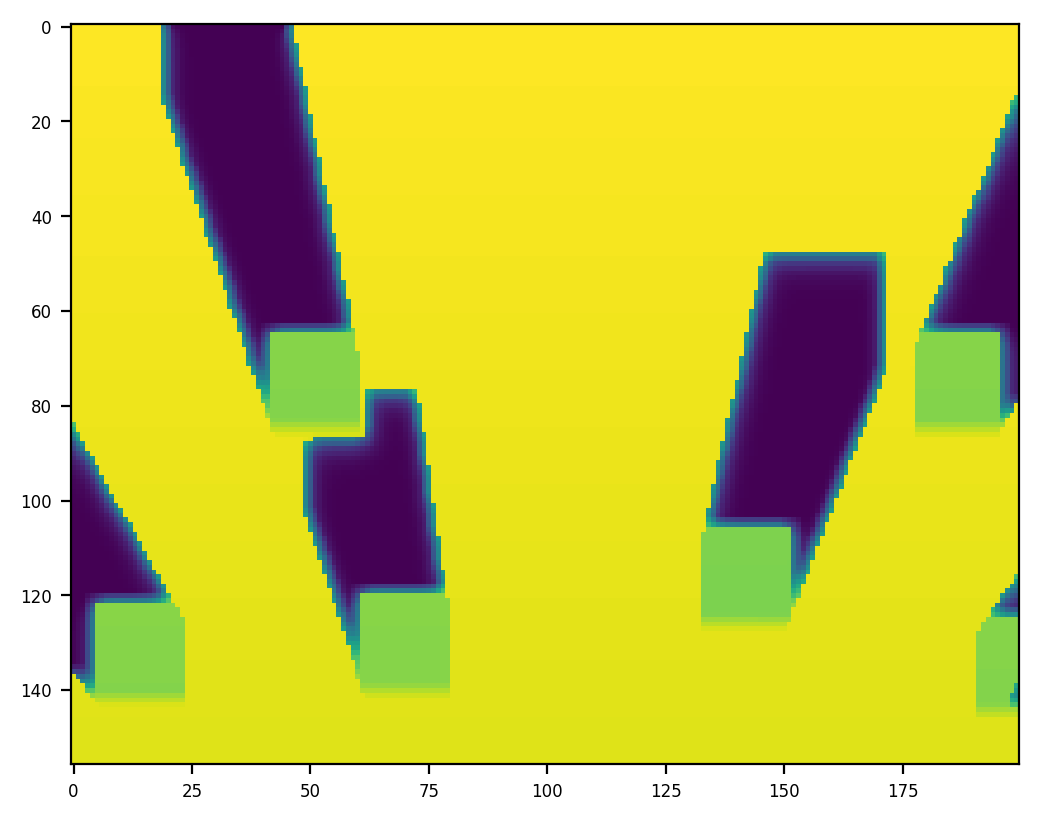

In [9]:
import cv2
import numpy as np

# Load the depth image
depth_image = ortho_projected_img.copy()

# Detect shadows (example: simple thresholding)
shadow_mask = (depth_image == 0).astype(np.uint8)

# Define the neighborhood size for averaging depth values
neighborhood_size = 5

# Iterate over shadow pixels and inpaint their depth values
for i in range(depth_image.shape[0]):
    for j in range(depth_image.shape[1]):
        if shadow_mask[i, j] == 1:
            # Find the neighborhood region
            i_start = max(i - neighborhood_size // 2, 0)
            i_end = min(i + neighborhood_size // 2 + 1, depth_image.shape[0])
            j_start = max(j - neighborhood_size // 2, 0)
            j_end = min(j + neighborhood_size // 2 + 1, depth_image.shape[1])

            # Calculate the average depth value of the region
            avg_depth = np.mean(depth_image[i_start:i_end, j_start:j_end])

            # Replace the shadow depth value with the average depth
            depth_image[i, j] = avg_depth

# Visualize the updated depth image
plt.imshow(depth_image)


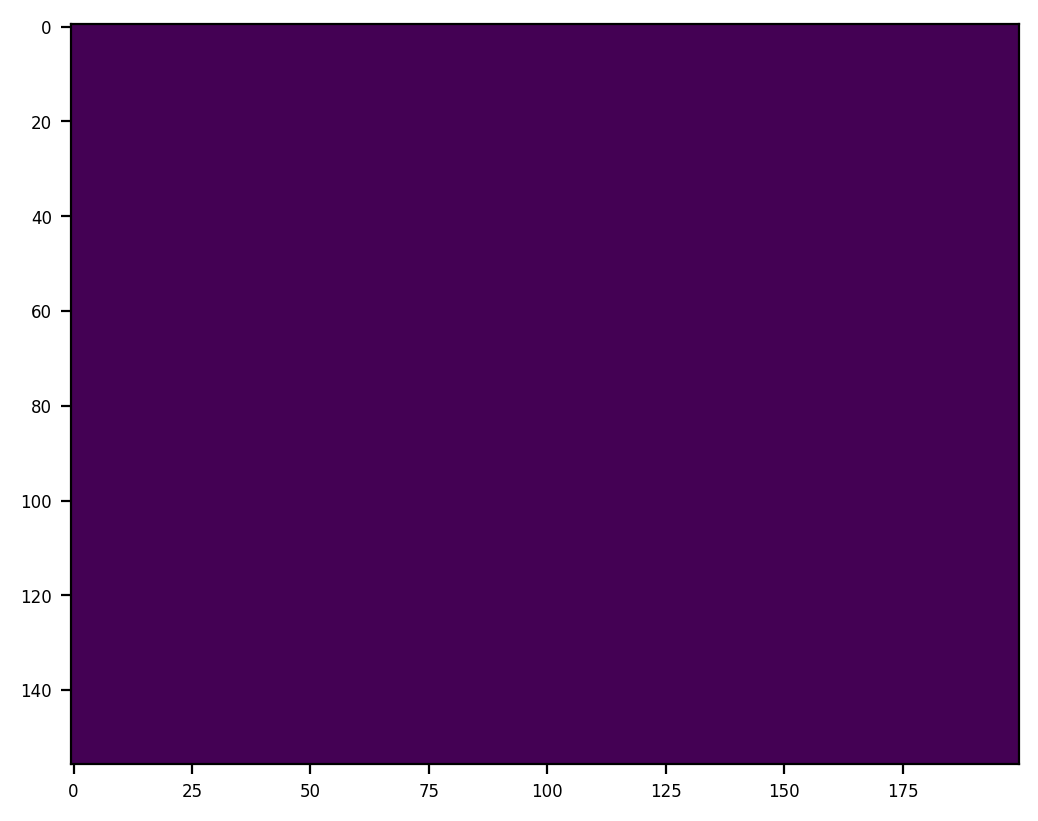

In [11]:
plt.imshow(object_mask)

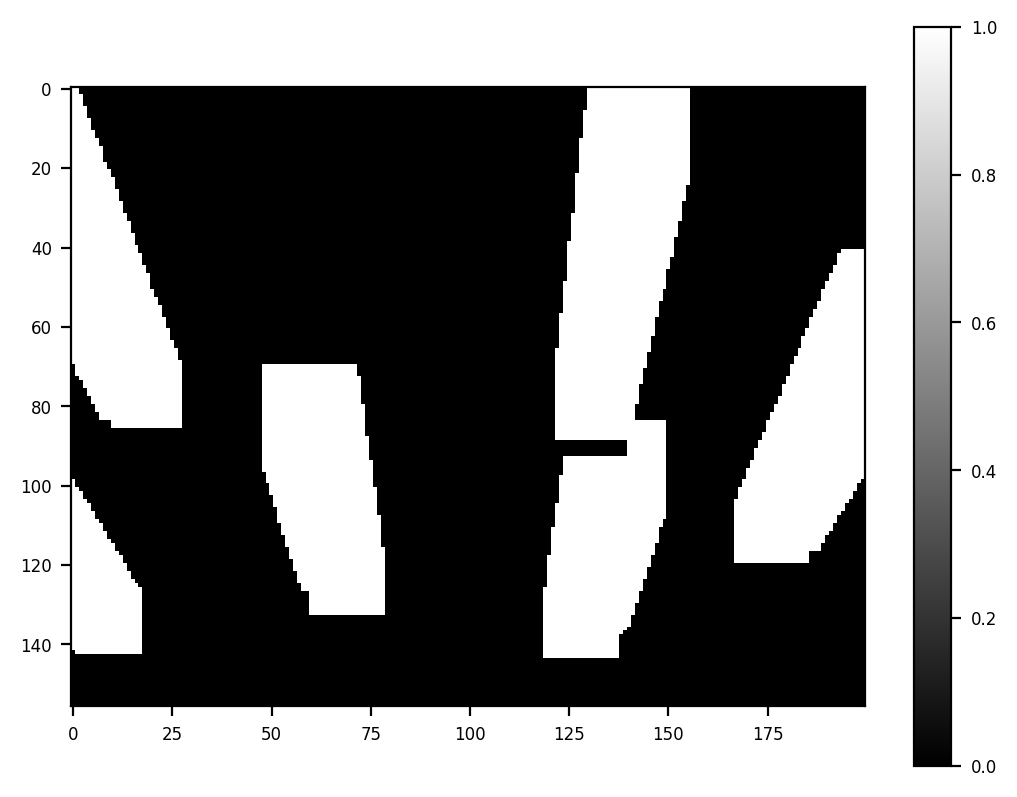

In [19]:
threshold = 0.5  # Adjust this threshold based on your depth image
occupancy_grid = (depth_image < threshold).astype(int)

plt.imshow(occupancy_grid, cmap='gray')
plt.colorbar()
plt.show()


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the depth image
depth_image = depth_img.copy()

# Step 2: Preprocess the depth image
threshold_value = 100  # Adjust the threshold as per your image
binary_image = cv2.threshold(depth_image, threshold_value, 255, cv2.THRESH_BINARY)[1]
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

# Step 3: Detect the object's shadow
block_size = 11  # Adjust the block size as per your image and shadow characteristics
constant = 2  # Adjust the constant value as per your image and shadow characteristics
shadow_mask = cv2.adaptiveThreshold(
    cleaned_image.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, constant
)

# Step 4: Create a grid map
grid_size = (100, 100)  # Define the size of the grid map (e.g., 100x100)
resolution = 0.1  # Define the resolution of each grid cell (e.g., 0.1 units)
grid_map = np.zeros(grid_size)

for x in range(cleaned_image.shape[0]):
    for y in range(cleaned_image.shape[1]):
        if cleaned_image[x, y] > 0:
            grid_x = int(x / resolution)
            grid_y = int(y / resolution)
            grid_map[grid_x, grid_y] = 1  # Occupied area

        if shadow_mask[x, y] > 0:
            grid_x = int(x / resolution)
            grid_y = int(y / resolution)
            grid_map[grid_x, grid_y] = 2  # Shadow area

# Step 5: Visualize the grid map
plt.imshow(grid_map, cmap='coolwarm')
plt.colorbar()
plt.show()


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'adaptiveThreshold'


In [15]:
def binary_filter(occupied_image):
    occupied_i, occupied_j = np.where(occupied_image>0)
    positive_value = np.array([1 for (i, j) in zip(occupied_i, occupied_j)])
    occupied_image[occupied_i, occupied_j] = positive_value
    return occupied_image

def transform_scene_image(rawImage):
    temp = distance.cdist(rawImage.T, rawImage.T, 'euclidean')
    temp = np.sum(temp, axis=0)
    free_table_idx = np_argmin(temp)

    TABLE_DEPTH = np.tile(rawImage[:,free_table_idx], reps=(1,200))

    minval = np.min(TABLE_DEPTH)
    maxval = np.max(TABLE_DEPTH)
    GROUNDED_TABLE_DEPTH = TABLE_DEPTH - minval
    GroundedImage = rawImage - minval
    No_occulsion_image = np.where(GroundedImage<-0.5, GROUNDED_TABLE_DEPTH, GroundedImage)
    No_BackGround_image = No_occulsion_image - GROUNDED_TABLE_DEPTH
    fliped_image = -np.where(No_BackGround_image>0, np.zeros_like(No_BackGround_image), No_BackGround_image)
    temp = fliped_image

    for i in range(10):
        south_image = np.roll(temp, 1, axis = 0)
        north_image = np.roll(temp, -1, axis = 0)
        east_image  = np.roll(temp, 1, axis = 1)
        west_image  = np.roll(temp, -1, axis = 1)

        if i % 2 ==0:
            temp = np.where((south_image+north_image+east_image+west_image)/4 < 0.01, np.zeros_like(temp), temp)
        if i % 2 ==1:
            temp = (south_image+north_image+east_image+west_image)/4
    clean_image = temp / (maxval-minval)
    plt.imshow(clean_image)
    return clean_image

def occupancy_mapping(raw_image, occ_map_w, occ_map_h):
    temp = distance.cdist(raw_image.T, raw_image.T, 'euclidean')
    temp = np.sum(temp, axis=0)
    free_table_idx = np.unravel_index((temp).argmin(), temp.shape)
    table_depth = np.tile(raw_image[:,free_table_idx], reps=(1,200))
    # print(table_depth)
    occupied_image = raw_image-table_depth
    print(occupied_image)

    occupied_image = binary_filter(occupied_image)
    plt.imshow(occupied_image)

    occupied_image = cv2.resize(occupied_image, (occ_map_w, occ_map_h), interpolation = cv2.INTER_CUBIC)
    occupied_image = binary_filter(occupied_image)
    # plt.savefig("./data/occ_mapping.png")
    c_vecor = occupied_image.reshape(-1)
    return c_vecor

def np_argmin(A:np):
    return np.unravel_index(A.argmin(), A.shape)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

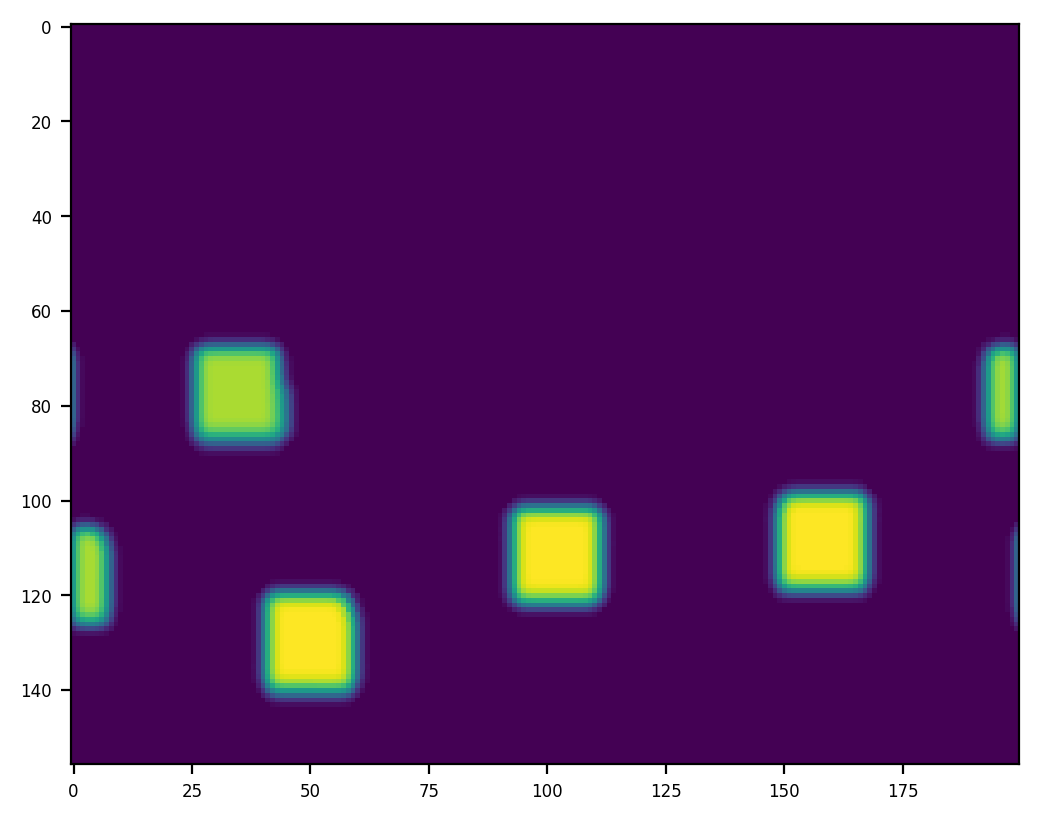

In [16]:
transform_scene_image(ortho_projected_img)

# occupancy_mapping(ortho_projected_img,12,8)

In [22]:
p_cam,R_cam = env.get_pR_body(body_name='camera_center')


In [23]:
from util import pr2t

T_cam = pr2t(p_cam,R_cam)
homo_inv_mat = np.linalg.inv(T_cam)

In [24]:
homo_inv_mat

array([[ 0.  , -1.  , -0.  ,  0.  ],
       [-0.71, -0.  , -0.71,  1.13],
       [ 0.71,  0.  , -0.71,  0.76],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def project_XY(cleaned_point_cloud, edge = 0.01, SAVE=None):
    # assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

    # project points onto the XY plane by ignoring the Z coordinate
    projected_points = cleaned_point_cloud[:, [1,0]]

    # compute extent of points in XY plane
    min_x, min_y = np.min(projected_points, axis=0)
    max_x, max_y = np.max(projected_points, axis=0)

    # compute center of circle
    center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

    # compute radius of circle
    radius = (max_x - min_x)/ 2
    # plot the circle and points
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1, c='k')
    # circle = plt.Circle((center_x, center_y), radius, fill=False)
    
    # plt.xlim(center_x-radius-edge, center_x+radius+edge)
    plt.ylim(center_y-radius-edge, center_y+radius+edge)

    if SAVE is not None:
        plt.axis("off")
        plt.savefig(SAVE, pad_inches=0, bbox_inches='tight', transparent=True)
    plt.axis('on')

    info = dict(center_x = center_x, center_y = center_y, radius = radius, edge = edge)
    return ax,fig, info

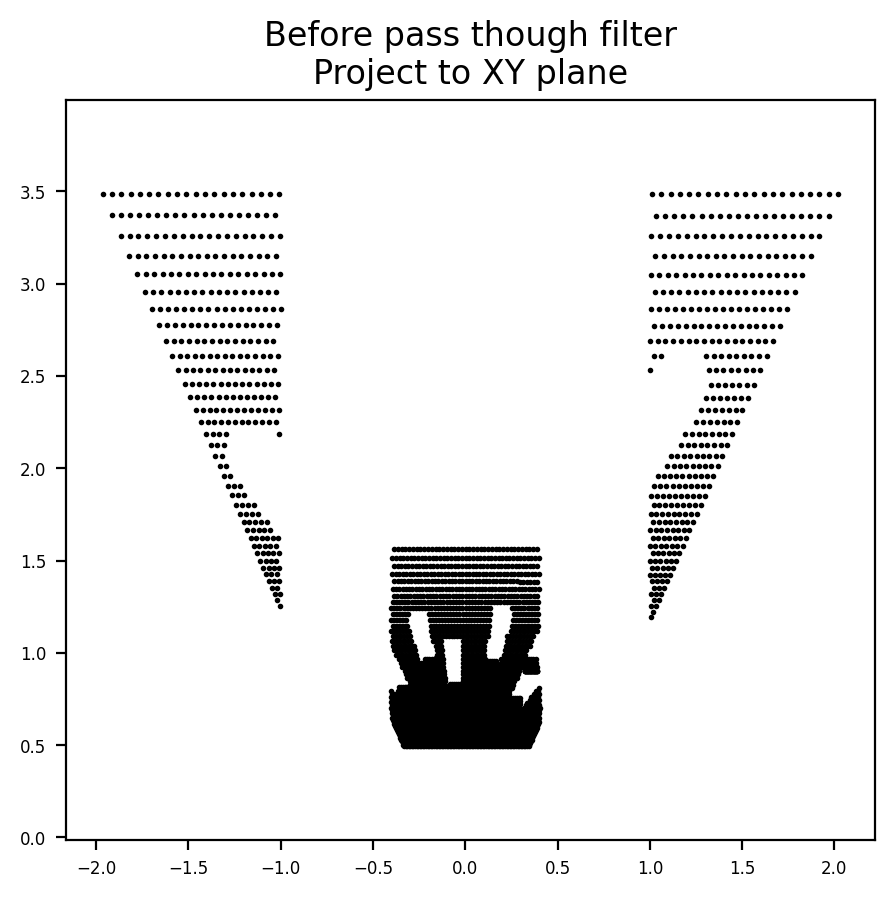

In [26]:
project_XY(pcd, edge = 0.01, SAVE= None)
plt.title("Before pass though filter\n"+'Project to XY plane')
plt.show()

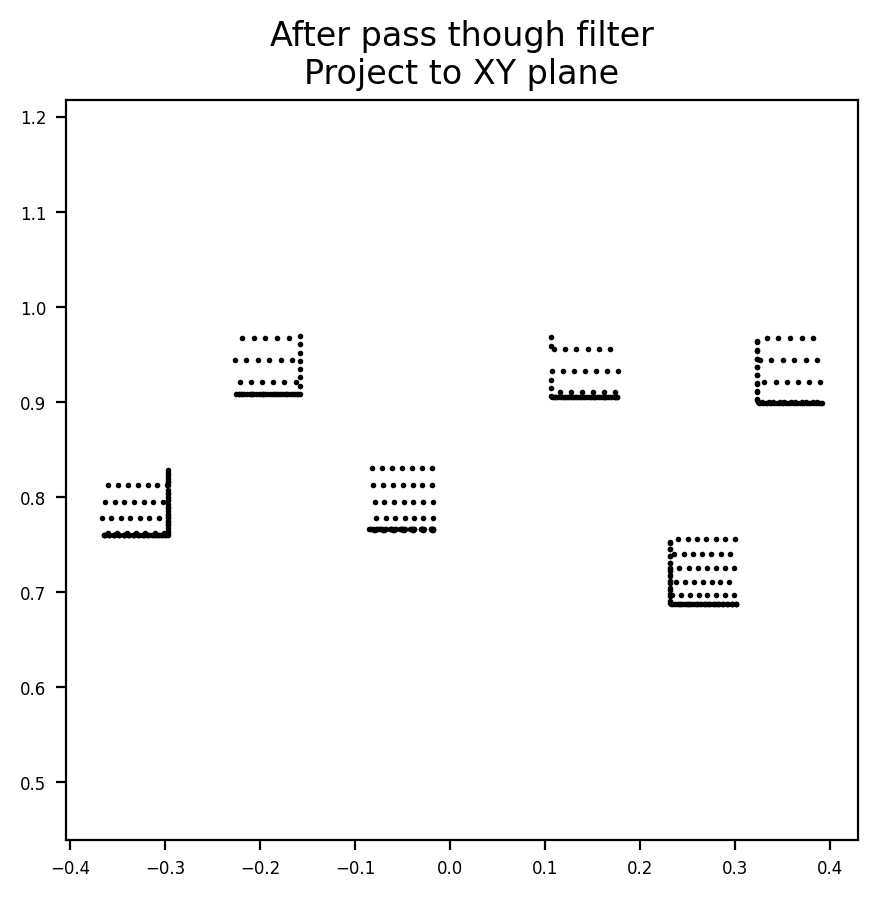

In [27]:
# Set the range limits for the passthrough filter along a specific axis
axis = 2  # 0 for x-axis, 1 for y-axis, 2 for z-axis
min_limit = 0.85
max_limit = 1.5

# Apply the passthrough filter along the specified axis
filtered_pcd = pcd[(pcd[:, axis] >= min_limit) & (pcd[:, axis] <= max_limit)]
project_XY(filtered_pcd, edge = 0.01, SAVE= './data/proj_xy_pcd.png')
plt.title("After pass though filter\n"+'Project to XY plane')
plt.show()

### Interactive viewer

In [28]:
# env.open_interactive_viewer()
print ("Done.")

Done.
